# Implementation of Vanilla GANs model
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [3]:
import numpy as np
import datetime
import scipy.misc

In [4]:
MODEL_NAME = 'VanillaGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def to_cuda(x):
    return x.to(DEVICE)

In [6]:
def get_sample_image(G, n_noise=100):
    """
        save sample 100 images
    """
    for num in range(10):
        for i in range(10):
            z = to_cuda(torch.randn(1, n_noise))
            y_hat = G(z)
            line_img = torch.cat((line_img, y_hat.view(28, 28)), dim=1) if i > 0 else y_hat.view(28, 28)
        all_img = torch.cat((all_img, line_img), dim=0) if num > 0 else line_img
    img = all_img.cpu().data.numpy()
    return img

In [7]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 200),
            nn.ReLU(),
            nn.Dropout(),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Dropout(),
        )
        self.layer3 = nn.Sequential(
            nn.Linear(200, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer1(y_)
        y_ = self.layer2(y_)
        y_ = self.layer3(y_)
        return y_

In [8]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 200),
            nn.LeakyReLU(0.2),
            nn.Linear(200, 200),
            nn.LeakyReLU(0.2),
            nn.Linear(200, num_classes),
            nn.Tanh()
        )
        
    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [9]:
D = to_cuda(Discriminator())
G = to_cuda(Generator())

In [10]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))]
)

In [11]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [12]:
batch_size = 64

In [13]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [14]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters())
G_opt = torch.optim.Adam(G.parameters())

In [15]:
max_epoch = 100 # need more than 200 epochs for training generator
step = 0
n_critic = 3 # for training more k steps about Discriminator
n_noise = 100

In [16]:
D_labels = to_cuda(torch.ones(batch_size)) # Discriminator Label to real
D_fakes = to_cuda(torch.zeros(batch_size)) # Discriminator Label to fake

In [17]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        step += 1
        # Training Discriminator
        x = to_cuda(images)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = to_cuda(torch.randn(batch_size, n_noise))
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = to_cuda(torch.randn(batch_size, n_noise))
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 1000 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.data[0], G_loss.data[0]))
        
        if epoch % 5 == 0:
            G.eval()
            img = get_sample_image(G)
            scipy.misc.imsave('sample/{}_epoch_{}_type1.jpg'.format(MODEL_NAME, epoch), img)
            G.train()

/home/yangyangii/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/yangyangii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/yangyangii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1/100, Step: 1000, D Loss: 0.33541572093963623, G Loss: 4.296747207641602
Epoch: 2/100, Step: 2000, D Loss: 0.17448781430721283, G Loss: 3.1404049396514893
Epoch: 3/100, Step: 3000, D Loss: 0.5423572063446045, G Loss: 2.0660290718078613
Epoch: 4/100, Step: 4000, D Loss: 0.6583614349365234, G Loss: 1.8657095432281494
Epoch: 5/100, Step: 5000, D Loss: 0.6916021108627319, G Loss: 1.7841814756393433
Epoch: 6/100, Step: 6000, D Loss: 0.9657713174819946, G Loss: 1.2007020711898804
Epoch: 7/100, Step: 7000, D Loss: 1.004629373550415, G Loss: 1.7700988054275513
Epoch: 8/100, Step: 8000, D Loss: 0.8277862071990967, G Loss: 1.6284986734390259
Epoch: 9/100, Step: 9000, D Loss: 1.0285593271255493, G Loss: 1.280022382736206
Epoch: 10/100, Step: 10000, D Loss: 1.001978874206543, G Loss: 1.2980926036834717
Epoch: 11/100, Step: 11000, D Loss: 0.9797093272209167, G Loss: 1.4614322185516357
Epoch: 12/100, Step: 12000, D Loss: 0.932427167892456, G Loss: 1.3135441541671753
Epoch: 13/100, Step: 1300

## Sample

/home/yangyangii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  This is separate from the ipykernel package so we can avoid doing imports until


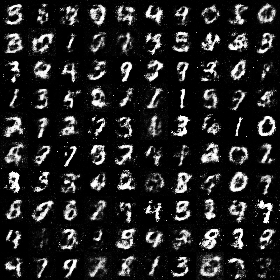

In [18]:
# generation to image
G.eval()
scipy.misc.toimage(get_sample_image(G))

In [14]:
# Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')